In [34]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.src.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [35]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 15
BATCH_SIZE = 64

In [36]:
train_path = "../data/raw/spider_classification/train"
val_path = "../data/raw/spider_classification/valid"
test_path = "../data/raw/spider_classification/test"

In [37]:
# Data generators
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2185 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


In [38]:
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
base_model.trainable = False

In [39]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [40]:
model = Model(inputs=base_model.input, outputs=output)

In [41]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# Callbacks
checkpoint_cb = ModelCheckpoint('resnet_model.keras', save_best_only=True)
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

In [43]:
# Warm-up training
history1 = model.fit(train_generator,
                     validation_data=val_generator,
                     epochs=5,  # just to initialize head weights
                     callbacks=[earlystop_cb, checkpoint_cb],
                     verbose=1)

C:\Users\Owner\PycharmProjects\tarantula-species-image-classifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0656 - loss: 3.0546 - val_accuracy: 0.1333 - val_loss: 2.6686
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0875 - loss: 2.8311 - val_accuracy: 0.1067 - val_loss: 2.6287
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.0910 - loss: 2.7507 - val_accuracy: 0.1467 - val_loss: 2.6021
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0951 - loss: 2.6802 - val_accuracy: 0.2267 - val_loss: 2.5698
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1394 - loss: 2.6248 - val_accuracy: 0.2400 - val_loss: 2.5395


In [44]:
# Unfreeze top N layers of ResNet50 for fine-tuning
for layer in base_model.layers[-50:]:  # You can adjust the number here
    layer.trainable = True

In [45]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-6, verbose=1)

In [47]:
# Training
history2 = model.fit(train_generator,
                     validation_data=val_generator,
                     epochs=15,
                     callbacks=[earlystop_cb, checkpoint_cb, reduce_lr],
                     verbose=1)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.1099 - loss: 2.7379 - val_accuracy: 0.1467 - val_loss: 2.5731 - learning_rate: 1.0000e-05
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.2625 - loss: 2.3619 - val_accuracy: 0.1600 - val_loss: 2.5842 - learning_rate: 1.0000e-05
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3416 - loss: 2.1273 - val_accuracy: 0.1600 - val_loss: 2.5973 - learning_rate: 1.0000e-05
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4323 - loss: 1.8835 - val_accuracy: 0.1200 - val_loss: 2.5547 - learning_rate: 1.0000e-05
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4943 - loss: 1.7089 - val_accuracy: 0.1867 - val_loss: 2.4216 - learning_rate: 1.0000e-05
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5109 - loss: 1.6147 - val_accuracy: 0.3733 - val_loss: 2.1893 - learning_rate: 1.0000e-05
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5476 - loss

In [48]:
# Evaluation on test data
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.6298 - loss: 1.0086
Test Accuracy: 0.64


In [49]:
# Classification report
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


In [50]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


Classification Report:
                         precision    recall  f1-score   support

            Black Widow       0.67      0.40      0.50         5
         Blue Tarantula       0.80      0.80      0.80         5
            Bold Jumper       1.00      0.80      0.89         5
     Brown Grass Spider       0.33      0.60      0.43         5
   Brown Recluse Spider       0.00      0.00      0.00         5
        Deinopis Spider       0.75      0.60      0.67         5
      Golden Orb Weaver       0.62      1.00      0.77         5
            Hobo Spider       0.00      0.00      0.00         5
        Huntsman Spider       0.33      0.60      0.43         5
  Ladybird Mimic Spider       0.83      1.00      0.91         5
         Peacock Spider       1.00      0.80      0.89         5
     Red Knee Tarantula       1.00      0.60      0.75         5
Spiny-backed Orb-weaver       1.00      1.00      1.00         5
  White Kneed Tarantula       0.62      1.00      0.77         5


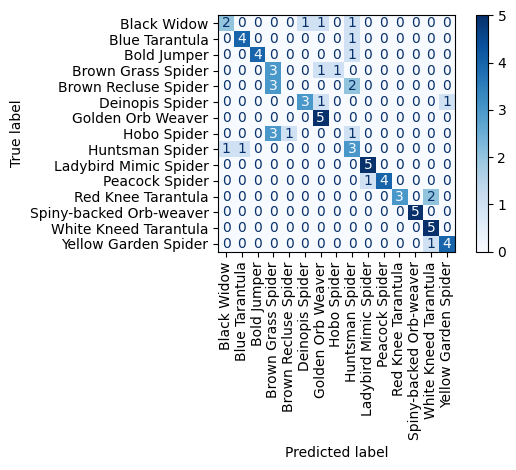

In [51]:
#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.tight_layout()
plt.show()

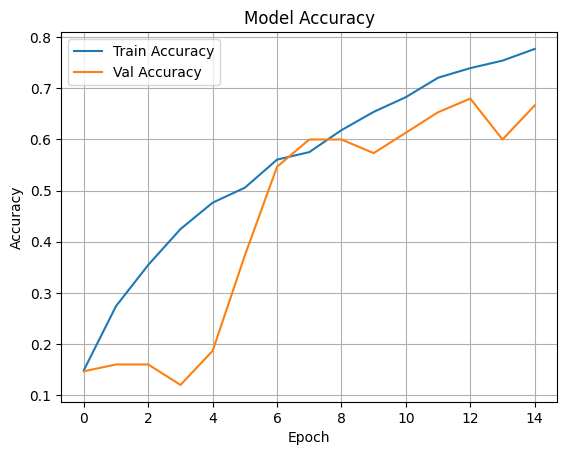

In [52]:
# Training history plot
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

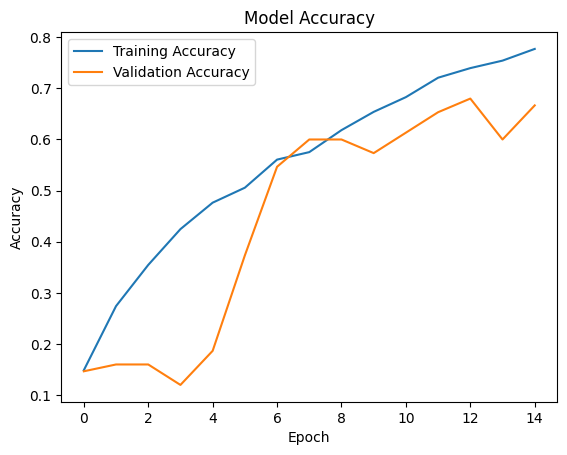

In [53]:
# Accuracy plot
plt.figure()
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

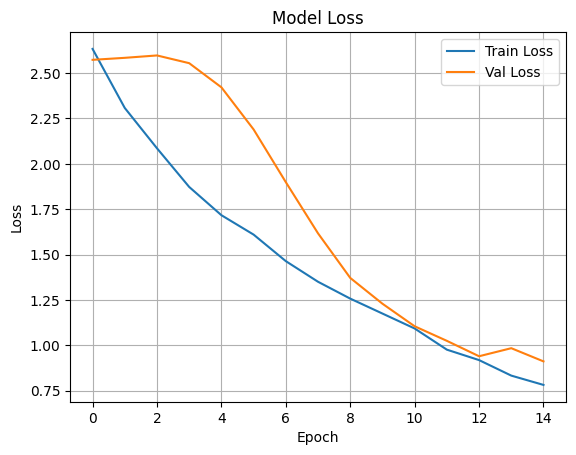

In [54]:
# Loss plot
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 59,073,967 (225.35 MB)

 Trainable params: 17,478,927 (66.68 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 34,957,856 (133.35 MB)

In [56]:
model.save("resnet_model.keras")